# Predictive Maintenance Notebook

This notebook handles two datasets:
- **CMAPSS**: Turbofan engine degradation (regression for RUL prediction).
- **PRONOSTIA**: Bearing vibration data (classification for failure detection).

Sections are separated for clarity.

## Install Dependencies (Run Once)

In [1]:
!pip install xgboost shap

DEPRECATION: neuralplot 0.0.8 has a non-standard dependency specifier matplotlib>=3.1numpy>=1.16. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of neuralplot or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Imports (All at the Top)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from scipy.stats import skew, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Section 1: CMAPSS Dataset (Regression for RUL)

### 1.1 Load CMAPSS Data

In [3]:
cmapss_dir = "../data/raw/CMAPSS/"
train_file = os.path.join(cmapss_dir, "train_FD001.txt")

col_names = ['unit_number', 'time_in_cycles',
             'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
            [f'sensor_{i}' for i in range(1, 22)]

train_FD001 = pd.read_csv(train_file, sep=" ", header=None)
train_FD001 = train_FD001.dropna(axis=1, how='all')
train_FD001.columns = col_names

print("CMAPSS Training Data (FD001):")
print(train_FD001.head())
print("\nTail:")
print(train_FD001.tail())

CMAPSS Training Data (FD001):
   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4                  100.0    518.67    642.37   1582.85   1406.22     14.62   

   ...  sensor_12  s

### 1.2 Preprocess CMAPSS Data (Generate RUL, Select Features, Cap RUL, Scale)

In [4]:
# Generate uncapped RUL
max_cycles = train_FD001.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
train_FD001 = train_FD001.merge(max_cycles, on='unit_number', how='left')
train_FD001['RUL'] = train_FD001['max_cycle'] - train_FD001['time_in_cycles']
train_FD001.drop(columns=['max_cycle'], inplace=True)

print(train_FD001[['unit_number', 'time_in_cycles', 'RUL']].head())

# Select features and cap RUL
selected_features = ['unit_number', 'time_in_cycles', 'RUL',
                     'operational_setting_1', 'operational_setting_2', 'operational_setting_3',
                     'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
                     'sensor_11', 'sensor_12', 'sensor_15', 'sensor_17', 'sensor_20']
train_FD001 = train_FD001[selected_features]

MAX_RUL = 125
train_FD001['RUL'] = train_FD001['RUL'].clip(upper=MAX_RUL)

print(train_FD001[['unit_number', 'time_in_cycles', 'RUL']].head(20))

# Scale features
scaler = StandardScaler()
cols_to_scale = [c for c in train_FD001.columns if c not in ['unit_number', 'time_in_cycles', 'RUL']]
train_FD001[cols_to_scale] = scaler.fit_transform(train_FD001[cols_to_scale])

   unit_number  time_in_cycles  RUL
0            1               1  191
1            1               2  190
2            1               3  189
3            1               4  188
4            1               5  187
    unit_number  time_in_cycles  RUL
0             1               1  125
1             1               2  125
2             1               3  125
3             1               4  125
4             1               5  125
5             1               6  125
6             1               7  125
7             1               8  125
8             1               9  125
9             1              10  125
10            1              11  125
11            1              12  125
12            1              13  125
13            1              14  125
14            1              15  125
15            1              16  125
16            1              17  125
17            1              18  125
18            1              19  125
19            1              20  125


### 1.3 Train/Test Split for CMAPSS (Group-Aware to Avoid Leakage)

In [5]:
X_cmapss = train_FD001.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y_cmapss = train_FD001['RUL']
groups_cmapss = train_FD001['unit_number']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X_cmapss, y_cmapss, groups_cmapss))

X_train_cmapss, X_val_cmapss = X_cmapss.iloc[train_idx], X_cmapss.iloc[val_idx]
y_train_cmapss, y_val_cmapss = y_cmapss.iloc[train_idx], y_cmapss.iloc[val_idx]

### 1.4 Models for CMAPSS

#### 1.4.1 XGBoost Regression

In [6]:
dtrain = xgb.DMatrix(X_train_cmapss, label=y_train_cmapss)
dval = xgb.DMatrix(X_val_cmapss, label=y_val_cmapss)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

model_xgb = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, 'Validation')], verbose_eval=50)

y_pred_xgb = model_xgb.predict(dval)
rmse_xgb = np.sqrt(mean_squared_error(y_val_cmapss, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val_cmapss, y_pred_xgb)

print(f'CMAPSS XGBoost → RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}')

[0]	Validation-rmse:38.75104
[50]	Validation-rmse:19.93488
[100]	Validation-rmse:19.98000
[150]	Validation-rmse:20.07826
[199]	Validation-rmse:20.19397
CMAPSS XGBoost → RMSE: 20.19, MAE: 14.98


#### 1.4.2 LSTM Regression (Example on Unit 1)

In [7]:
def create_sequences(data, target, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(target[i + window])
    return np.array(X), np.array(y)

unit1 = train_FD001[train_FD001['unit_number'] == 1]
X_seq, y_seq = create_sequences(unit1.drop(columns=['unit_number', 'time_in_cycles', 'RUL']).values,
                                unit1['RUL'].values)

split = int(0.8 * len(X_seq))
X_train_lstm, X_val_lstm = X_seq[:split], X_seq[split:]
y_train_lstm, y_val_lstm = y_seq[:split], y_seq[split:]

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model_lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm),
                         epochs=20, batch_size=32, verbose=1)

C:\Users\Blue\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 9006.7510 - mae: 91.6729 - val_loss: 194.7362 - val_mae: 16.9706
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9684.8115 - mae: 91.5324 - val_loss: 199.4411 - val_mae: 17.2074
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9339.9561 - mae: 91.6015 - val_loss: 202.6770 - val_mae: 17.3545
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8518.2764 - mae: 90.2167 - val_loss: 204.1102 - val_mae: 17.4082
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8166.0049 - mae: 86.8373 - val_loss: 204.1864 - val_mae: 17.4029
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8514.3184 - mae: 87.7991 - val_loss: 194.4017 - val_mae: 17.0749
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7887.6123 - mae: 85.6758 - val_loss: 166.2615 - val_mae: 16.0274
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7202.9443 - mae: 81.9232 - val_loss: 160.0861 - val_mae: 15.7506
Epoch 9/20
5/5 ━━━━━━━━

### 1.5 SHAP Explanations for CMAPSS XGBoost

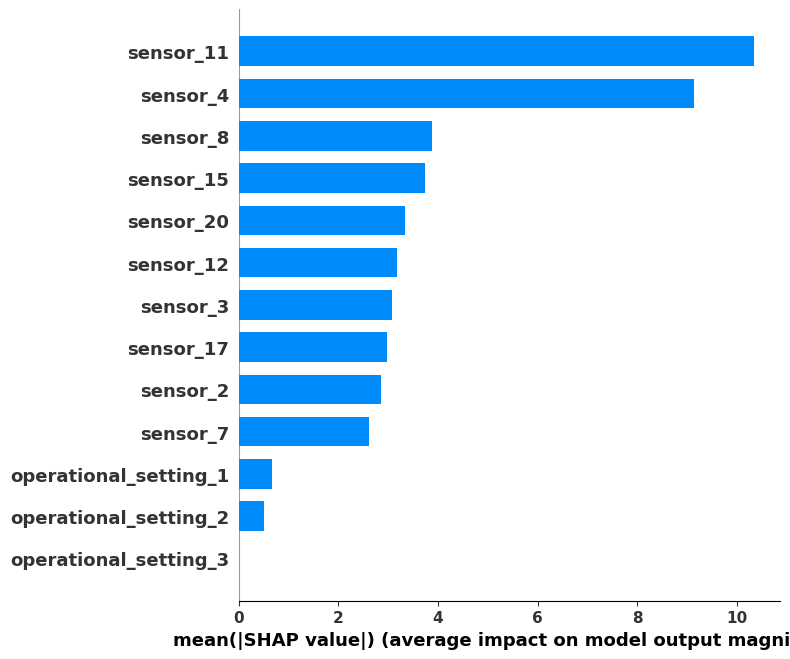

In [8]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_val_cmapss)
shap.summary_plot(shap_values, X_val_cmapss, plot_type='bar')

## Section 2: PRONOSTIA Dataset (Classification for Failure)

### 2.1 Load and Extract Features from PRONOSTIA Data

In [9]:
def fft_band_energy(signal, fs=25600, bands=[(0, 1000), (1000, 5000), (5000, 10000)]):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1 / fs)
    fft_vals = np.abs(fft(signal)) ** 2
    energies = []
    for low, high in bands:
        mask = (freqs >= low) & (freqs < high)
        energies.append(np.sum(fft_vals[mask]) / N)
    return energies

def extract_features_from_file(file_path):
    df = pd.read_csv(file_path, header=None)
    df.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horiz_accel', 'Vert_accel']
    feats = {}
    for axis in ['Horiz_accel', 'Vert_accel']:
        signal = df[axis].values
        feats[f'RMS_{axis}'] = np.sqrt(np.mean(signal ** 2))
        feats[f'Kurtosis_{axis}'] = pd.Series(signal).kurt()
        feats[f'Skew_{axis}'] = skew(signal)
        feats[f'Entropy_{axis}'] = entropy(np.abs(signal) + 1e-10)
        feats[f'CrestFactor_{axis}'] = np.max(np.abs(signal)) / (np.sqrt(np.mean(signal ** 2)) + 1e-8)
        energies = fft_band_energy(signal)
        for i, e in enumerate(energies):
            feats[f'FFTband{i + 1}_{axis}'] = e
    return feats

# Example usage on one file
pronostia_dir = "../data/raw/PRONOSTIA/Learning_set/Bearing1_1/"
acc_file = os.path.join(pronostia_dir, "acc_00001.csv")
df_acc = pd.read_csv(acc_file, header=None)
df_acc.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horiz_accel', 'Vert_accel']

print('Shape:', df_acc.shape)
print(df_acc.head())

features_example = extract_features_from_file(acc_file)
print('Features from acc_00001.csv:', features_example)

Shape: (2560, 6)
   Hour  Minute  Second  Microsecond  Horiz_accel  Vert_accel
0     9      39      39      65664.0        0.552      -0.146
1     9      39      39      65703.0        0.501      -0.480
2     9      39      39      65742.0        0.138       0.435
3     9      39      39      65781.0       -0.423       0.240
4     9      39      39      65820.0       -0.802       0.020
Features from acc_00001.csv: {'RMS_Horiz_accel': 0.56174565773522, 'Kurtosis_Horiz_accel': -0.12937474006868177, 'Skew_Horiz_accel': -0.00471106707861808, 'Entropy_Horiz_accel': 7.57022023674449, 'CrestFactor_Horiz_accel': 3.578131733714442, 'FFTband1_Horiz_accel': 14.485748021246781, 'FFTband2_Horiz_accel': 339.5130212588877, 'FFTband3_Horiz_accel': 44.87625019917607, 'RMS_Vert_accel': 0.4358014232064301, 'Kurtosis_Vert_accel': -0.03280164198939506, 'Skew_Vert_accel': 0.002713478645300573, 'Entropy_Vert_accel': 7.567291891876442, 'CrestFactor_Vert_accel': 3.650745221956111, 'FFTband1_Vert_accel': 3.0488

### 2.2 Merge Processed PRONOSTIA CSVs

In [10]:
base_dir = "../data/raw/PRONOSTIA/Learning_set/"
out_dir = "../data/processed/"

all_records = []
for bearing_folder in os.listdir(base_dir):
    out_path = os.path.join(out_dir, f"{bearing_folder}.csv")
    if os.path.exists(out_path):
        df = pd.read_csv(out_path)
        df['bearing_id'] = bearing_folder
        all_records.append(df)

features_df = pd.concat(all_records, ignore_index=True)

print('Bearings included:', features_df['bearing_id'].unique())
print('Shape:', features_df.shape)
print(features_df.head())

Bearings included: ['Bearing1_1' 'Bearing1_2' 'Bearing2_1' 'Bearing2_2' 'Bearing3_1'
 'Bearing3_2']
Shape: (7534, 28)
   RMS_Horiz_accel  Kurtosis_Horiz_accel  Skew_Horiz_accel  \
0         0.561746             -0.129375         -0.004711   
1         0.535112             -0.082464         -0.025791   
2         0.531158              0.035801         -0.005016   
3         0.554833              0.045851         -0.080165   
4         0.566652             -0.183492         -0.034187   

   Entropy_Horiz_accel  CrestFactor_Horiz_accel  FFTband1_Horiz_accel  \
0             7.570220                 3.578132          37083.514934   
1             7.568644                 3.578687          39956.206555   
2             7.557264                 3.578971          31764.857937   
3             7.553766                 3.442476          38503.494738   
4             7.566496                 3.118317          55759.340178   

   FFTband2_Horiz_accel  FFTband3_Horiz_accel  WaveletEnergy_L0_Horiz_

### 2.3 Train/Test Split for PRONOSTIA (Group-Aware)

In [11]:
X_pronostia = features_df.drop(columns=['label', 'file', 'bearing_id'], errors='ignore')
y_pronostia = features_df['label']
groups_pronostia = features_df['bearing_id']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X_pronostia, y_pronostia, groups_pronostia))

X_train_pronostia, X_test_pronostia = X_pronostia.iloc[train_idx], X_pronostia.iloc[test_idx]
y_train_pronostia, y_test_pronostia = y_pronostia.iloc[train_idx], y_pronostia.iloc[test_idx]

### 2.4 Models for PRONOSTIA

#### 2.4.1 Logistic Regression

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=5000, solver='lbfgs'))
])

pipe.fit(X_train_pronostia, y_train_pronostia)
y_pred = pipe.predict(X_test_pronostia)
print(classification_report(y_test_pronostia, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2938
           1       0.63      1.00      0.77       736

    accuracy                           0.88      3674
   macro avg       0.81      0.93      0.85      3674
weighted avg       0.93      0.88      0.89      3674



#### 2.4.2 Random Forest Classifier

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pronostia, y_train_pronostia)
y_pred_rf = rf_clf.predict(X_test_pronostia)
print('PRONOSTIA Random Forest (Grouped Split)')
print(classification_report(y_test_pronostia, y_pred_rf))

joblib.dump(rf_clf, '../models/pronostia_rf_baseline.pkl')

PRONOSTIA Random Forest (Grouped Split)
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2938
           1       0.74      0.61      0.67       736

    accuracy                           0.88      3674
   macro avg       0.82      0.78      0.80      3674
weighted avg       0.87      0.88      0.87      3674



['../models/pronostia_rf_baseline.pkl']

#### 2.4.3 XGBoost Classifier

In [14]:
xgb_clf = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train_pronostia, y_train_pronostia)
y_pred_xgb = xgb_clf.predict(X_test_pronostia)
print('PRONOSTIA XGBoost Classifier')
print(classification_report(y_test_pronostia, y_pred_xgb))

PRONOSTIA XGBoost Classifier
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2938
           1       1.00      0.43      0.60       736

    accuracy                           0.89      3674
   macro avg       0.94      0.72      0.77      3674
weighted avg       0.90      0.89      0.87      3674



#### 2.4.4 Unsupervised: One-Class SVM and Isolation Forest

In [15]:
X_healthy = X_train_pronostia[y_train_pronostia == 0]

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
oc_svm.fit(X_healthy)
y_pred_svm = oc_svm.predict(X_test_pronostia)
y_pred_svm = (y_pred_svm == -1).astype(int)
print('One-Class SVM')
print(classification_report(y_test_pronostia, y_pred_svm))

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_healthy)
y_pred_iso = iso_forest.predict(X_test_pronostia)
y_pred_iso = (y_pred_iso == -1).astype(int)
print('Isolation Forest')
print(classification_report(y_test_pronostia, y_pred_iso))

One-Class SVM
              precision    recall  f1-score   support

           0       1.00      0.28      0.43      2938
           1       0.26      1.00      0.41       736

    accuracy                           0.42      3674
   macro avg       0.63      0.64      0.42      3674
weighted avg       0.85      0.42      0.43      3674

Isolation Forest
              precision    recall  f1-score   support

           0       1.00      0.12      0.21      2938
           1       0.22      1.00      0.36       736

    accuracy                           0.29      3674
   macro avg       0.61      0.56      0.28      3674
weighted avg       0.84      0.29      0.24      3674



### 2.5 SHAP Explanations for PRONOSTIA XGBoost

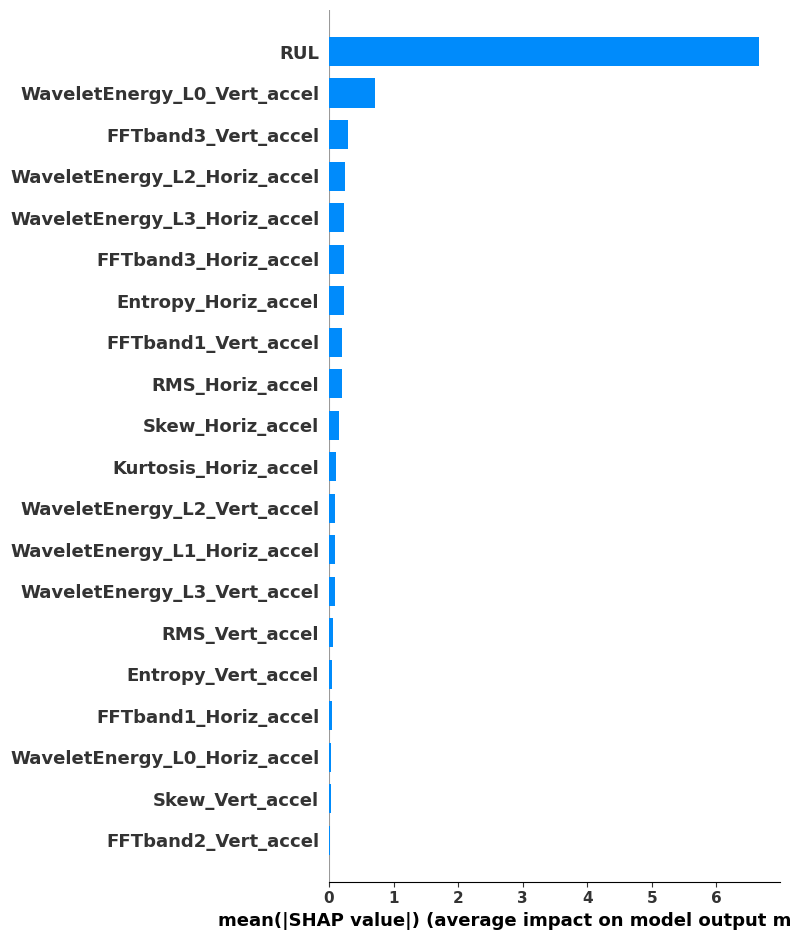

In [16]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_pronostia)
shap.summary_plot(shap_values, X_test_pronostia, plot_type='bar')

### 2.6 Visualizations for PRONOSTIA

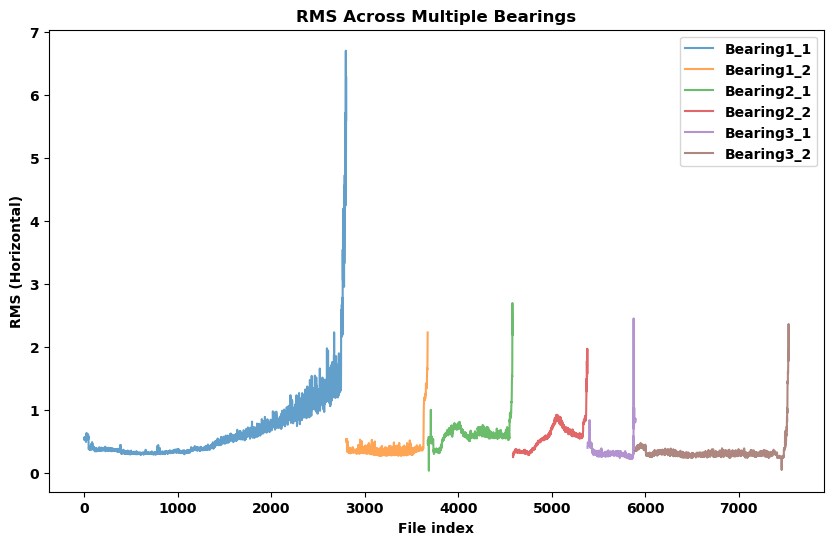

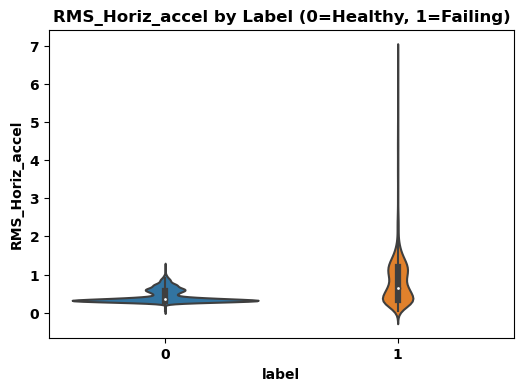

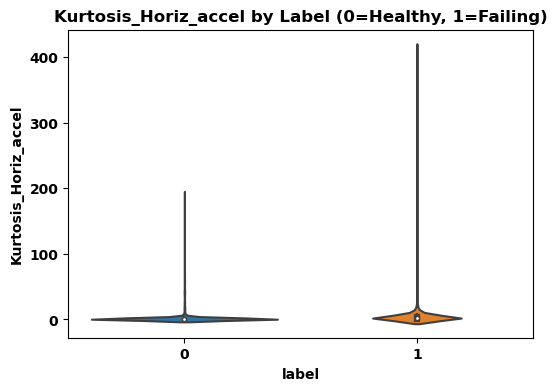

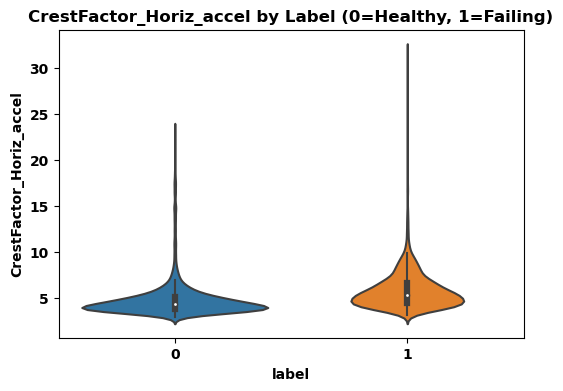

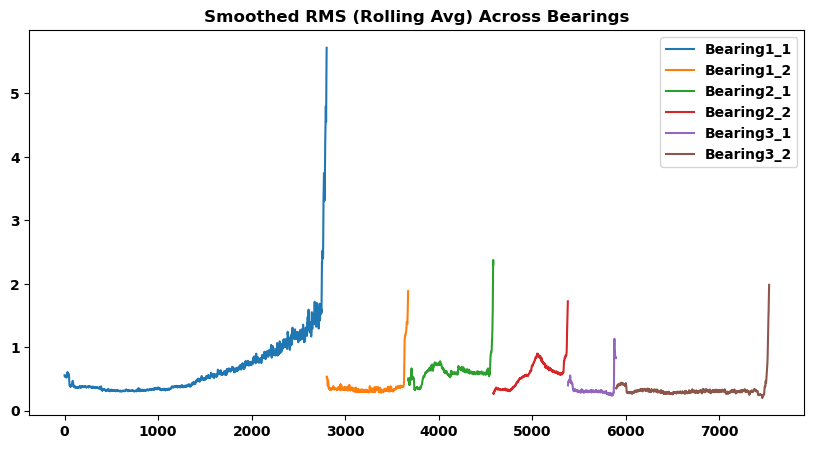

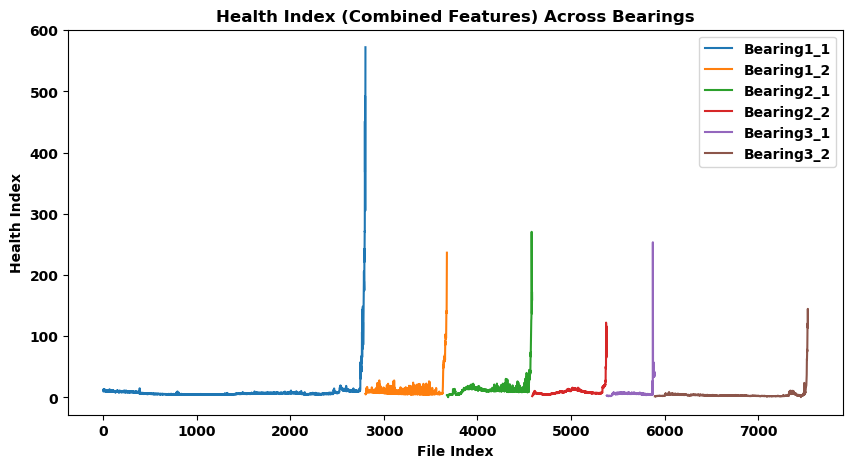

In [17]:
# RMS Across Bearings
plt.figure(figsize=(10, 6))
for bid in features_df['bearing_id'].unique():
    df_b = features_df[features_df['bearing_id'] == bid]
    plt.plot(df_b.index, df_b['RMS_Horiz_accel'], label=bid, alpha=0.7)
plt.legend()
plt.title('RMS Across Multiple Bearings')
plt.xlabel('File index')
plt.ylabel('RMS (Horizontal)')
plt.show()

# Violin Plots
for feat in ['RMS_Horiz_accel', 'Kurtosis_Horiz_accel', 'CrestFactor_Horiz_accel']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=features_df, x='label', y=feat)
    plt.title(f'{feat} by Label (0=Healthy, 1=Failing)')
    plt.show()

# Smoothed RMS
features_df_sorted = features_df.sort_values(by=['bearing_id', 'file'])
features_df_sorted['RMS_Horiz_accel_smooth'] = features_df_sorted.groupby('bearing_id')['RMS_Horiz_accel'].transform(lambda x: x.rolling(5, min_periods=1).mean())

plt.figure(figsize=(10, 5))
for bid in features_df['bearing_id'].unique():
    df_b = features_df_sorted[features_df_sorted['bearing_id'] == bid]
    plt.plot(df_b.index, df_b['RMS_Horiz_accel_smooth'], label=f'{bid}')
plt.legend()
plt.title('Smoothed RMS (Rolling Avg) Across Bearings')
plt.show()

# Health Index
features_df['health_index'] = (
    features_df['RMS_Horiz_accel'] +
    features_df['FFTband3_Horiz_accel'] * 0.0001 +
    features_df['RMS_Vert_accel']
)

plt.figure(figsize=(10, 5))
for bid in features_df['bearing_id'].unique():
    df_b = features_df[features_df['bearing_id'] == bid]
    plt.plot(df_b.index, df_b['health_index'], label=bid)
plt.legend()
plt.title('Health Index (Combined Features) Across Bearings')
plt.xlabel('File Index')
plt.ylabel('Health Index')
plt.show()